In [27]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.stats import gaussian_kde

The Metropolis-Hastings algorithm was used to model each distribution. For the first case, the algorithm was described in detail.

## Beta distribution

$$f_{a, b}(x) = \frac{\Gamma(a) + \Gamma(b)}{\Gamma(a + b)} \cdot x^{a-1} \cdot (1 - x)^{b-1}, \quad x \in (0, 1)
$$
The classic method for modeling beta distributions includes the following steps:
$$u \sim \text{U}[0, 1]$$
$$-\log(1 - u) \sim \text{Exp}(1)$$
$$X_1, \ldots, X_a \sim \text{Exp}(1) \Rightarrow X = X_1 + \ldots + X_a \sim \text{Gamma}(a, 1)$$
$$Y_1, \ldots, Y_b \sim \text{Exp}(1) \Rightarrow Y = Y_1 + \ldots + Y_b \sim \text{Gamma}(b, 1)$$
$$\frac{X}{X + Y} \sim \text{Beta}(a, b)$$  
But it is quite a hard process.  
  
The Metropolis-Hastings algorithm for this task:  
1) Generate X0 from Uniform distribution on [0, 1].
2) If X_i is a current state, then generate an "offer" u from U[0, 1].
3) Calculate
$$\alpha(x, u) = \frac{u^{a-1} \cdot (1 - u)^{b-1}}{x^{a-1} \cdot (1 - x)^{b-1}}$$  
4) Generate v from U[0, 1]. If v <= α, then X_(i+1) = u, else X_(i+1) = X_i



In [28]:
def betta_distr_model(a, b, n):
    X = np.empty(n)
    X[0] = rand()
    for i in range(n-1):
        u = rand()
        alpha_x_u = beta_f_distr(a, b, u) / beta_f_distr(a, b, X[i])
        v = rand()
        if v <= alpha_x_u:
            X[i + 1] = u
        else:
            X[i + 1] = X[i]
    return X

def beta_f_distr(a, b, x):
    return x**(a - 1) * (1 - x)**(b - 1)

In [29]:
# Beta distribution parameters
a1, b1 = 1, 3
a2, b2 = 2, 2
# Number of iterations
n = 700000
# Size of histogram
hist_size = 70
# Results, Marcov Chain
X1 = betta_distr_model(a1, b1, n)
X2 = betta_distr_model(a2, b2, n)

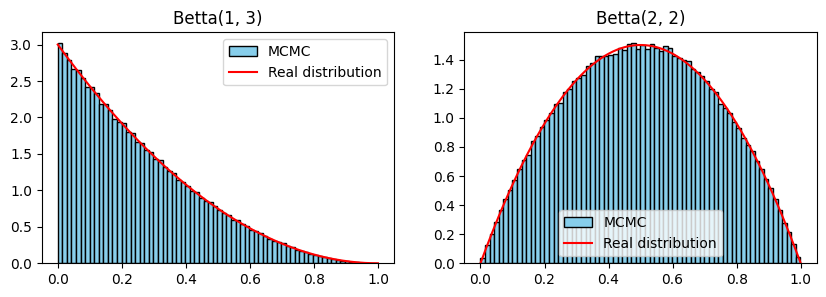

In [30]:
plt.rcParams['figure.figsize'] = [10, 3]
plt.subplot(1, 2, 1)
plt.hist(X1, bins=hist_size, density=True, color='skyblue', edgecolor='black', label='MCMC')
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a1, b1)
plt.plot(x, y, color='r', label='Real distribution')
plt.legend()
plt.title(f'Betta({a1}, {b1})')
plt.subplot(1, 2, 2)
plt.hist(X2, bins=hist_size, density=True, color='skyblue', edgecolor='black', label='MCMC')
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a2, b2)
plt.plot(x, y, color='r', label='Real distribution')
plt.legend()
plt.title(f'Betta({a2}, {b2})')
plt.show()

## Multivariate normal distribution

$$\begin{pmatrix} x \\ y \end{pmatrix} \sim N\left(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}\right)
$$

In [31]:
def multiv_norm_distr_model(n, ro):
    X = np.zeros(n)
    Y = np.zeros(n)
    for i in range(n - 1):
        x_new = np.random.normal(ro * Y[i], 1 - ro**2)
        y_new = np.random.normal(ro * x_new, 1 - ro**2)
        alpha_f = mn_f_distr(x_new, y_new, ro) / mn_f_distr(X[i], Y[i], ro)
        u = rand()
        if u <= alpha_f:
            X[i + 1] = x_new
            Y[i + 1] = y_new
        else:
            X[i + 1] = X[i]
            Y[i + 1] = Y[i]
    return X, Y

def mn_f_distr(x, y, ro):
    C = (2 * np.pi * np.sqrt(1 - ro**2))**(-1)
    A = np.exp(-(x**2 - 2 * ro * x * y + y**2) / 2 / (1 - ro**2))
    return C * A

In [32]:
ro = 0.6
n = 10000
hist_size = 30
X, Y = multiv_norm_distr_model(n, ro)

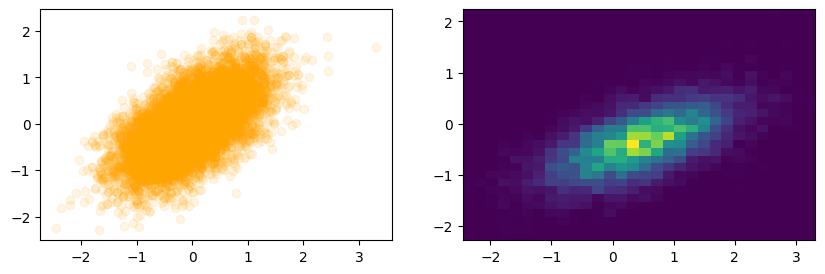

In [33]:
plt.subplot(1, 2, 1)
plt.scatter(X, Y, alpha=0.1, color='orange')
plt.subplot(1, 2, 2)
hist, xedges, yedges = np.histogram2d(X, Y, bins=hist_size)
plt.pcolormesh(xedges, yedges, hist)

## Other distributions

$$f(x, p, n) \sim {}C_n^x \cdot p^x \cdot (1 - p)^{n-x} \cdot \frac{4^n}{n!}$$


In [34]:
def XPN_distr_model(x0, p0, n0, m):
    X = np.empty(m).astype('uint')
    P = np.empty(m)
    N = np.empty(m).astype('uint')
    X[0], P[0], N[0] = x0, p0, n0
    for i in range(1, m):
        X[i] = int(np.random.binomial(N[i - 1], P[i - 1]))
        P[i] = np.random.beta(X[i] + 1, N[i - 1] - X[i] + 1)
        N[i] = int(np.random.poisson(4 * (1 -  P[i])) + X[i])
    return X, P, N

In [35]:
x0, p0, n0 = 1, 0.5, 8
m = 5000
X, P, N = XPN_distr_model(x0, p0, n0, m)

C:\Users\ladmin\AppData\Local\Temp\ipykernel_15040\2607628597.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


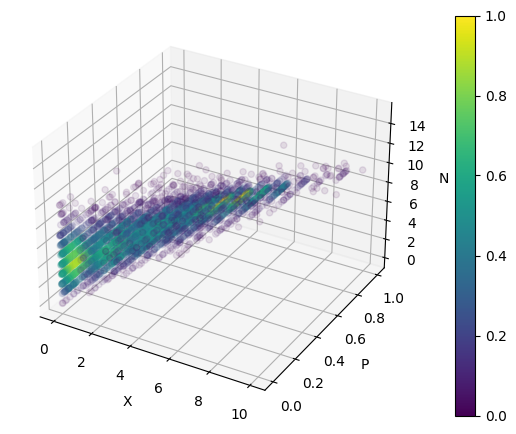

In [36]:
plt.rcParams['figure.figsize'] = [5, 5]
data = np.vstack([X, P, N])
kde = gaussian_kde(data)
density = kde(data)
norm = Normalize(vmin=density.min(), vmax=density.max())
density = norm(density)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X, P, N, c=density, alpha = 0.1, cmap='viridis')
sm = ScalarMappable(cmap='viridis')
sm.set_array(density)
ax.set_xlabel('X')
ax.set_ylabel('P')
ax.set_zlabel('N')
plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=0.9)
plt.colorbar(sm)
plt.show()